<a href="https://colab.research.google.com/github/AndreyKowal/Deep-Learning/blob/simple-solutions/Cars_3_classes_VGG16_TL%2BFT(93%25).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Необходимо создать, обучить нейронную сеть с точностью не менее 85% и упаковать её в архив для загрузки на демо-панель:
* создать нейронную сеть для распознавания марки автомобиля из 3х вариантов
* сохраните веса
* подготовить запуск модели "из коробки"
* подготовить архив с готовой нейронной сетью для загрузки в демо-панель


In [ ]:
# Сеть прямого распространения
from tensorflow.keras.models import Sequential 

# Базовые слои для свёрточных сетей
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# Работа с изображениями
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Оптимизаторы
from tensorflow.keras.optimizers import Adam     

# Используем для to_categoricall
from tensorflow.keras import utils               

# Для отрисовки изображений
from tensorflow.keras.preprocessing import image 

# импорт tensorflow
import tensorflow as tf

# Библиотека работы с массивами
import numpy as np

# Для отрисовки графиков
import matplotlib.pyplot as plt                  

# Для отрисовки изображений
from PIL import Image                            

# Для генерации случайных чисел 
import random                                    

# Для округления
import math                                      

# Для работы с файлами 
import os                                        

# модуль для отсчета времени
import time 

# Чистка ОЗУ
import gc

# Рисование графиков в ячейках Colab
%matplotlib inline

## Подготовка данных

In [ ]:
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l5/middle_fmr.zip', None, quiet=True)
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l6/car_test.zip', None, quiet=True) 

'car_test.zip'

In [ ]:
!unzip -q middle_fmr.zip -d /content/cars # Указываем путь к базе в Google Drive

In [ ]:
classes = os.listdir('cars')
print(classes)

['Ferrari', 'Renault', 'Mercedes']


In [ ]:
# Функция для вывода графиков 
def show_graph(history):
  plt.figure(figsize=(18,5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
  plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Доля верных ответов')
  plt.legend()

  plt.grid(which='major', color='black', alpha=0.3)
  plt.minorticks_on()
  plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], 
         label='Ошибка на обучающем наборе')
  plt.plot(history.history['val_loss'], 
         label='Ошибка на проверочном наборе')
  plt.xlabel('Эпоха обучения')
  plt.ylabel('Ошибка')
  plt.legend()

  plt.grid(which='major', color='black', alpha=0.3)
  plt.minorticks_on()
  plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

  plt.show()

In [ ]:
TRAIN_PATH = '/content/cars' # Папка с папками картинок, рассортированных по категориям
batch_size = 32  # Размер выборки
image_size= (224, 224) # Размер изображения

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_PATH ,
  validation_split=0.2,    # Устанавливаем разделение на обучающую и проверочную выборки
  subset="training",       # Эта выборка обучающая
  seed=123,                # закрепляем рандом для сравнения сетей
  image_size= image_size,
  batch_size= batch_size)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_PATH ,
  validation_split=0.2,
  subset="validation",     # Эта выборка проверочная
  seed=123,
  image_size= image_size,
  batch_size= batch_size)

Found 3427 files belonging to 3 classes.
Using 2742 files for training.
Found 3427 files belonging to 3 classes.
Using 685 files for validation.


In [ ]:
class_names = train_data.class_names # Определяем имена классов
print(class_names)

['Ferrari', 'Mercedes', 'Renault']


# Transfer learning

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE    # предварительная подгрузка датасета для ускорения и стабилизации

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE) 
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Аугментация в виде слоя для модели

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
  ])

In [ ]:
# Слой подготовки данных (у каждой модели свой)
preprocess_input = tf.keras.applications.vgg16.preprocess_input
gc.collect()

# Создание модели
image_shape = image_size + (3,)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=image_shape,
                         include_top=False,
                         weights='imagenet')

base_model.trainable = False
# base_model.summary()

global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Глобал пулинг
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax') # По количеству классов

# собираем полную модель 
inputs = tf.keras.Input(shape=(image_shape))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# компилируем
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0   

In [ ]:
initial_epochs = 80

CurrentTime = time.time() # Засекаем время для измерения времени обучения нейронной сети

# обучаем
hist_vgg16 = model.fit(train_data,
                    epochs=initial_epochs,
                    validation_data=val_data)

print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))

Epoch 1/80


86/86 [==============================] - 22s 234ms/step - loss: 3.8540 - accuracy: 0.3662 - val_loss: 2.6667 - val_accuracy: 0.4146
Epoch 2/80
86/86 [==============================] - 19s 223ms/step - loss: 3.1973 - accuracy: 0.3968 - val_loss: 2.2770 - val_accuracy: 0.4584
Epoch 3/80
86/86 [==============================] - 23s 273ms/step - loss: 2.8956 - accuracy: 0.4354 - val_loss: 2.0128 - val_accuracy: 0.4891
Epoch 4/80
86/86 [==============================] - 23s 270ms/step - loss: 2.5063 - accuracy: 0.4657 - val_loss: 1.8190 - val_accuracy: 0.5182
Epoch 5/80
86/86 [==============================] - 18s 211ms/step - loss: 2.4369 - accuracy: 0.4748 - val_loss: 1.6576 - val_accuracy: 0.5401
Epoch 6/80
86/86 [==============================] - 22s 261ms/step - loss: 2.2198 - accuracy: 0.4978 - val_loss: 1.5431 - val_accuracy: 0.5620
Epoch 7/80
86/86 [==============================] - 22s 258ms/step - loss: 2.1105 - accuracy: 0.5142 - val_loss: 1.4304 - val_accuracy: 0.5766
Epoch 8/80

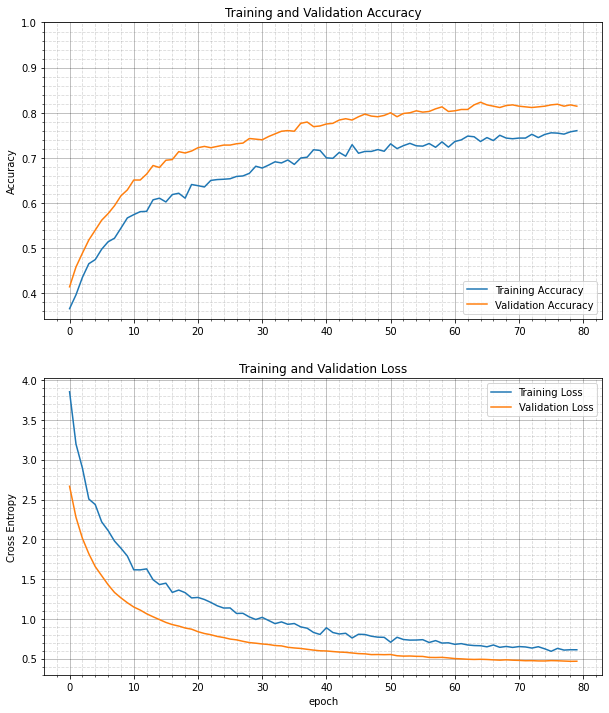

In [ ]:
acc = hist_vgg16.history['accuracy']
val_acc = hist_vgg16.history['val_accuracy']

loss = hist_vgg16.history['loss']
val_loss = hist_vgg16.history['val_loss']

plt.figure(figsize=(10, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.grid(which='major', color='black', alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.grid(which='major', color='black', alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

plt.show()

In [ ]:
# компилируем
lr = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= lr),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

second_step_epochs = 12
total_epochs =  initial_epochs + second_step_epochs

CurrentTime = time.time() # Засекаем время для измерения времени обучения нейронной сети

# обучаем
hist_vgg16_2 = model.fit(train_data,
                    epochs=total_epochs,
                    initial_epoch=hist_vgg16.epoch[-1],
                    validation_data=val_data)

print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))

Epoch 80/92


86/86 [==============================] - 22s 215ms/step - loss: 0.5787 - accuracy: 0.7699 - val_loss: 0.4661 - val_accuracy: 0.8161
Epoch 81/92
86/86 [==============================] - 19s 219ms/step - loss: 0.5907 - accuracy: 0.7622 - val_loss: 0.4662 - val_accuracy: 0.8146
Epoch 82/92
86/86 [==============================] - 18s 215ms/step - loss: 0.5903 - accuracy: 0.7640 - val_loss: 0.4662 - val_accuracy: 0.8161
Epoch 83/92
86/86 [==============================] - 18s 215ms/step - loss: 0.5700 - accuracy: 0.7684 - val_loss: 0.4660 - val_accuracy: 0.8161
Epoch 84/92
86/86 [==============================] - 19s 216ms/step - loss: 0.5972 - accuracy: 0.7538 - val_loss: 0.4655 - val_accuracy: 0.8175
Epoch 85/92
86/86 [==============================] - 19s 216ms/step - loss: 0.6014 - accuracy: 0.7640 - val_loss: 0.4652 - val_accuracy: 0.8161
Epoch 86/92
86/86 [==============================] - 19s 219ms/step - loss: 0.5977 - accuracy: 0.7593 - val_loss: 0.4649 - val_accuracy: 0.8146
Epoc

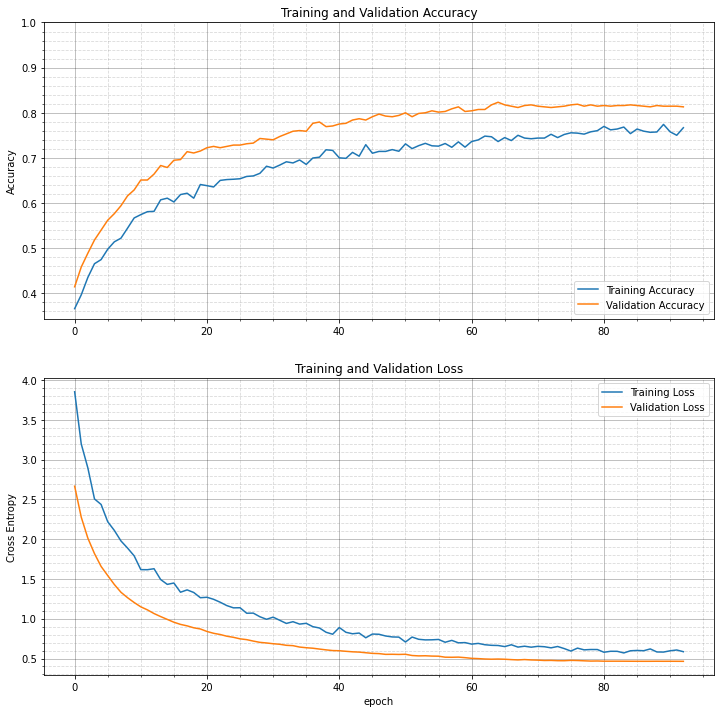

In [ ]:
# Вывод графиков 
acc += hist_vgg16_2.history['accuracy']
val_acc += hist_vgg16_2.history['val_accuracy']

loss += hist_vgg16_2.history['loss']
val_loss += hist_vgg16_2.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.grid(which='major', color='black', alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.grid(which='major', color='black', alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

plt.show()

# Fine tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  19


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 15

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
# компилируем
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.00001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_5   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_5 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_5   (None, 512)              0   

In [ ]:
len(model.trainable_variables)

8

In [ ]:
fine_tune_epochs = 25
total_epochs =  total_epochs + fine_tune_epochs

CurrentTime = time.time()                    # Засекаем время для измерения времени обучения нейронной сети

# обучаем
history_fine = model.fit(train_data,
                    epochs=total_epochs,
                    initial_epoch=hist_vgg16_2.epoch[-1],
                    validation_data=val_data)

print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))


Epoch 92/117


86/86 [==============================] - 23s 236ms/step - loss: 0.5469 - accuracy: 0.7746 - val_loss: 0.4188 - val_accuracy: 0.8409
Epoch 93/117
86/86 [==============================] - 22s 260ms/step - loss: 0.4652 - accuracy: 0.8209 - val_loss: 0.3613 - val_accuracy: 0.8657
Epoch 94/117
86/86 [==============================] - 20s 230ms/step - loss: 0.3807 - accuracy: 0.8454 - val_loss: 0.3536 - val_accuracy: 0.8745
Epoch 95/117
86/86 [==============================] - 20s 233ms/step - loss: 0.3568 - accuracy: 0.8618 - val_loss: 0.3224 - val_accuracy: 0.8861
Epoch 96/117
86/86 [==============================] - 20s 237ms/step - loss: 0.3028 - accuracy: 0.8815 - val_loss: 0.3025 - val_accuracy: 0.9022
Epoch 97/117
86/86 [==============================] - 23s 263ms/step - loss: 0.2800 - accuracy: 0.8957 - val_loss: 0.3057 - val_accuracy: 0.8949
Epoch 98/117
86/86 [==============================] - 20s 233ms/step - loss: 0.2565 - accuracy: 0.9026 - val_loss: 0.2799 - val_accuracy: 0.909

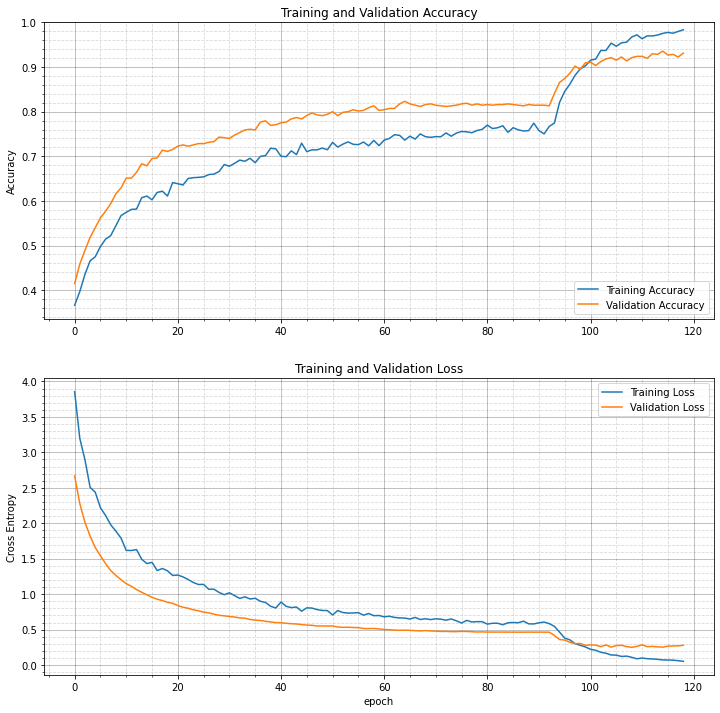

In [ ]:
# Вывод графиков 
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.grid(which='major', color='black', alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.grid(which='major', color='black', alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

plt.show()

In [ ]:
# компилируем
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.000001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

fine_tune_epochs_2 = 10
total_epochs =  total_epochs + fine_tune_epochs_2

CurrentTime = time.time()                    # Засекаем время для измерения времени обучения нейронной сети

# обучаем
history_fine_2 = model.fit(train_data,
                    epochs=total_epochs,
                    initial_epoch=history_fine.epoch[-1],
                    validation_data=val_data)

print('Время обучения: {:.0f} секунд ({:.2f} минут)'.format(time.time() - CurrentTime, (time.time() - CurrentTime)/60))


Epoch 117/127


86/86 [==============================] - 24s 243ms/step - loss: 0.0460 - accuracy: 0.9861 - val_loss: 0.2592 - val_accuracy: 0.9270
Epoch 118/127
86/86 [==============================] - 19s 226ms/step - loss: 0.0439 - accuracy: 0.9876 - val_loss: 0.2652 - val_accuracy: 0.9270
Epoch 119/127
86/86 [==============================] - 20s 234ms/step - loss: 0.0439 - accuracy: 0.9880 - val_loss: 0.2581 - val_accuracy: 0.9285
Epoch 120/127
86/86 [==============================] - 20s 233ms/step - loss: 0.0411 - accuracy: 0.9902 - val_loss: 0.2596 - val_accuracy: 0.9270
Epoch 121/127
86/86 [==============================] - 23s 266ms/step - loss: 0.0383 - accuracy: 0.9894 - val_loss: 0.2611 - val_accuracy: 0.9285
Epoch 122/127
86/86 [==============================] - 20s 231ms/step - loss: 0.0394 - accuracy: 0.9880 - val_loss: 0.2658 - val_accuracy: 0.9314
Epoch 123/127
86/86 [==============================] - 20s 237ms/step - loss: 0.0438 - accuracy: 0.9861 - val_loss: 0.2596 - val_accuracy:

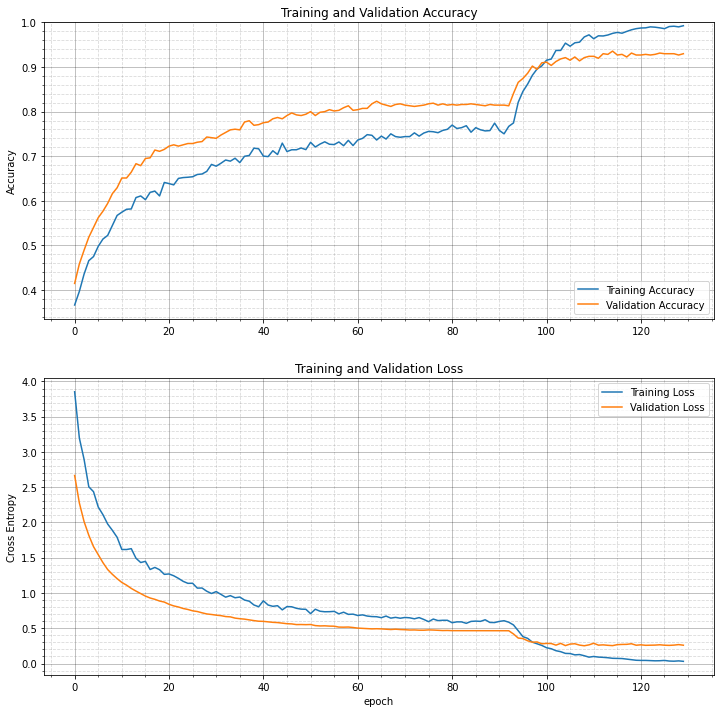

In [ ]:
# Вывод графиков 
acc += history_fine_2.history['accuracy']
val_acc += history_fine_2.history['val_accuracy']

loss += history_fine_2.history['loss']
val_loss += history_fine_2.history['val_loss']

plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.grid(which='major', color='black', alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.grid(which='major', color='black', alpha=0.3)
plt.minorticks_on()
plt.grid(which='minor', color='gray', linestyle='--', alpha=0.3)

plt.show()

# Сохраняем / загружаем параметры модели

In [ ]:
model.get_weights()[0][:, :, :, 0]

array([[[ 0.43062544,  0.55120575,  0.48315862],
        [ 0.37403473,  0.44040018,  0.411393  ],
        [-0.0615846 , -0.08161768, -0.0626955 ]],

       [[ 0.27610663,  0.34699485,  0.31414163],
        [ 0.03918808,  0.04118789,  0.05344049],
        [-0.36760747, -0.453605  , -0.40067217]],

       [[-0.05605693, -0.05718125, -0.0468296 ],
        [-0.26162675, -0.32985088, -0.28152663],
        [-0.35010603, -0.48464975, -0.41515967]]], dtype=float32)

In [ ]:
# Имя и желаемый путь к будущему файлу
path_weight = 'weights_vgg16.h5' 

# сохранение весов модели
model.save_weights(path_weight) 

In [ ]:
from google.colab import files               # Функция для скачивания данных на локальный компьютер

files.download(filename='weights_vgg16.h5')       # Скачивание готового архива

print('Веса загружены на компьтер')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Веса загружены на компьтер


In [ ]:
model1.get_weights()[0][:, :, :, 0]

array([[[ 0.43062544,  0.55120575,  0.48315862],
        [ 0.37403473,  0.44040018,  0.411393  ],
        [-0.0615846 , -0.08161768, -0.0626955 ]],

       [[ 0.27610663,  0.34699485,  0.31414163],
        [ 0.03918808,  0.04118789,  0.05344049],
        [-0.36760747, -0.453605  , -0.40067217]],

       [[-0.05605693, -0.05718125, -0.0468296 ],
        [-0.26162675, -0.32985088, -0.28152663],
        [-0.35010603, -0.48464975, -0.41515967]]], dtype=float32)

# Проверяем точность предсказания

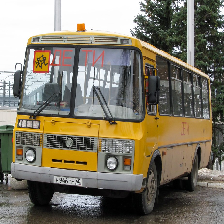

1/1 [==============================] - 0s 21ms/step
Результат распознавания:
Ferrari        0.00%
Mercedes       0.00%
Renault       100.00%

Изображен(а):  Renault


In [ ]:
# Путь к файлу изображения
test_path = '/content/9.jpg' 

size = (224, 224)
class_names = ['Ferrari', 'Mercedes', 'Renault']

img = image.load_img(test_path, target_size=size)
display(img)

img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

pred = model.predict(img)
print('Результат распознавания:')

for i, cl in enumerate(class_names):    
    # Вывод предсказания сети для каждого класса
    print('{:<14s}{:6.2%}'.format(cl, pred[0, i]))
print()

cls_image = np.argmax(pred)
print('Изображен(а): ', class_names[cls_image])

# Подготовка данных для архивации

In [ ]:
def predict(img_path='./1.jpg', weights_path='./weights.h5'):
  
  size = (224, 224)
  image_shape = size + (3,)
  class_names = ['Ferrari', 'Mercedes', 'Renault']
  classes = {0: class_names[0], 1: class_names[1], 2: class_names[2]}

  # Слой подготовки данных (у каждой модели свой)
  preprocess_input = tf.keras.applications.vgg16.preprocess_input

  # Создание модели
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=image_shape,
                         include_top=False,
                         weights=None) 

  # base_model.summary()
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Глобал пулинг
  prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax') # По количеству классов

  # собираем полную модель 
  inputs = tf.keras.Input(shape=(image_shape))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  
  # загрузка весов
  model.load_weights(weights_path)  

  img = image.load_img(img_path, target_size=size)
  img = image.img_to_array(img)
  img = np.array(img, dtype='float64') / 255.
  img = np.expand_dims(img, axis=0)

  cls_image = np.argmax(model.predict(img))
  print('Изображен(а): ', classes[cls_image])

In [ ]:
predict(img_path='/content/3.jpg', weights_path='/content/weights_vgg16.h5')

1/1 [==============================] - 8s 8s/step
Изображен(а):  Ferrari


In [ ]:
text_code = '''

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image 

def predict(img_path='./1.jpg', weights_path='./weights.h5'):
  
  size = (224, 224)
  image_shape = size + (3,)
  class_names = ['Ferrari', 'Mercedes', 'Renault']
  classes = {0: class_names[0], 1: class_names[1], 2: class_names[2]}

  # Слой подготовки данных (у каждой модели свой)
  preprocess_input = tf.keras.applications.vgg16.preprocess_input

  # Создание модели
  base_model = tf.keras.applications.vgg16.VGG16(input_shape=image_shape,
                         include_top=False,
                         weights=None) 

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # Глобал пулинг
  prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax') # По количеству классов

  # Cобираем полную модель 
  inputs = tf.keras.Input(shape=(image_shape))
  x = preprocess_input(inputs)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  
  # загрузка весов
  model.load_weights(weights_path)  

  img = image.load_img(img_path, target_size=size)
  img = image.img_to_array(img)
  img = np.expand_dims(img, axis=0)

  cls_image = np.argmax(model.predict(img))
  print(classes[cls_image])

'''

# Запись содержимого переменной в файл скрипта

with open('script.py', 'w') as f:  # Создание / открытие файла 
    f.write(text_code)             # Запись в файл значения переменной text_code

In [ ]:
label_txt = '''

Ferrari
F
Mercedes
M
Renault
R

'''

with open('label.txt', 'w') as f:  # Создание / открытие файла 
    f.write(label_txt.strip())     # Запись в файл значения переменной

In [ ]:
import os
from zipfile import ZipFile as Zip             # Модуль для работы с zip-архивами

# Список всех файлов
integrate_files = ['weights_vgg16.h5', 'script.py', 'label.txt', *[f'{i}.jpg' for i in range(1, 7)]]

zipArchive = Zip('/content/archive.zip', 'w')  # Открытие файла, если такого не существует - будет создан новый

for file in integrate_files:                   # Для всех всем нужных файлов:
    if os.path.exists(file):                   # Если файл существует,
        zipArchive.write(file)                 # то добавление его в архив
    else:
        print(f'Файл {file} отсутствует!')     # иначе вывод на экран названия отсутствующего файла

zipArchive.close()                             # В финале архив следует закрыть, как и обычный файл

In [ ]:
from google.colab import files               # Функция для скачивания данных на локальный компьютер

files.download(filename='archive.zip')       # Скачивание готового архива

print('Архив загружен')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Архив загружен
